<a href="https://colab.research.google.com/github/Griffin-Jordan/StormStocks/blob/main/Reddit_Sentiment_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.1 MB/s eta 0:00:00


In [90]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path = '/content/drive/My Drive/DS440/unique_data.csv'

In [114]:
# Now, read the CSV file
df = pd.read_csv(file_path)


In [146]:
df = pd.DataFrame(df)

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

df['Title_Sentiment'] = df['Title'].astype(str).apply(lambda title: sia.polarity_scores(title)['compound'])

# Convert 'Comments' to strings as well, to avoid TypeError with non-string types
df['Comments_Sentiment'] = df['Comments'].astype(str).apply(lambda comments: sia.polarity_scores(comments)['compound'])
# Display the updated DataFrame

In [147]:
average_scores = df.groupby('ticker')[['Title_Sentiment', 'Comments_Sentiment']].mean().reset_index()

# Display the resulting DataFrame
# print(average_scores)

In [148]:
# Normalize the average sentiment scores
average_scores['Average_Sentiment'] = average_scores[['Title_Sentiment', 'Comments_Sentiment']].mean(axis=1)
average_scores["norm_score"] = average_scores['Average_Sentiment'] - average_scores['Average_Sentiment'].min()
average_scores["norm_score"] /= average_scores["norm_score"].max()

In [123]:
ticker = "AAPL"
data = pd.DataFrame()
data[ticker] = pdr.get_data_yahoo(ticker, start="2023-1-1")['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [150]:
log_returns = np.log(1 + data.pct_change())
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()
np.array(drift)
x = np.random.rand(10,2)
Z = norm.ppf(np.random.rand(10,2))
t_intervals = 60
iterations = 10
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
for t in range(1, t_intervals):
  price_list[t] = price_list[t - 1] * daily_returns[t]

In [151]:
sentiment_weight = average_scores.loc[average_scores['ticker'] == ticker, 'norm_score'].iloc[0]


# Adjust drift and standard deviation according to the sentiment weight
# This is a simple example; the exact formula should be based on your investment model
adjusted_drift = drift.values * sentiment_weight
adjusted_stdev = stdev.values * np.sqrt(sentiment_weight)  # This is an assumption; adjust as needed

# Calculate daily returns using the adjusted drift and volatility
daily_returns = np.exp(adjusted_drift + adjusted_stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

# Assuming S0 is the last adjusted close price
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

# Generate the price list for each day
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]
average_price_path = price_list.mean(axis=1)

In [152]:
actual_data = data[-120:]

# Last date from actual data
last_actual_date = actual_data.index[-1]

# Generate forecast dates starting from the day after the last actual date
forecast_dates = pd.date_range(start=last_actual_date + pd.Timedelta(days=1), periods=60)

# Assuming `forecasted_prices` is your 60-day forecast
forecasted_prices = average_price_path

forecast_series = pd.Series(forecasted_prices, index=forecast_dates)

full_series = pd.concat([actual_data, forecast_series])

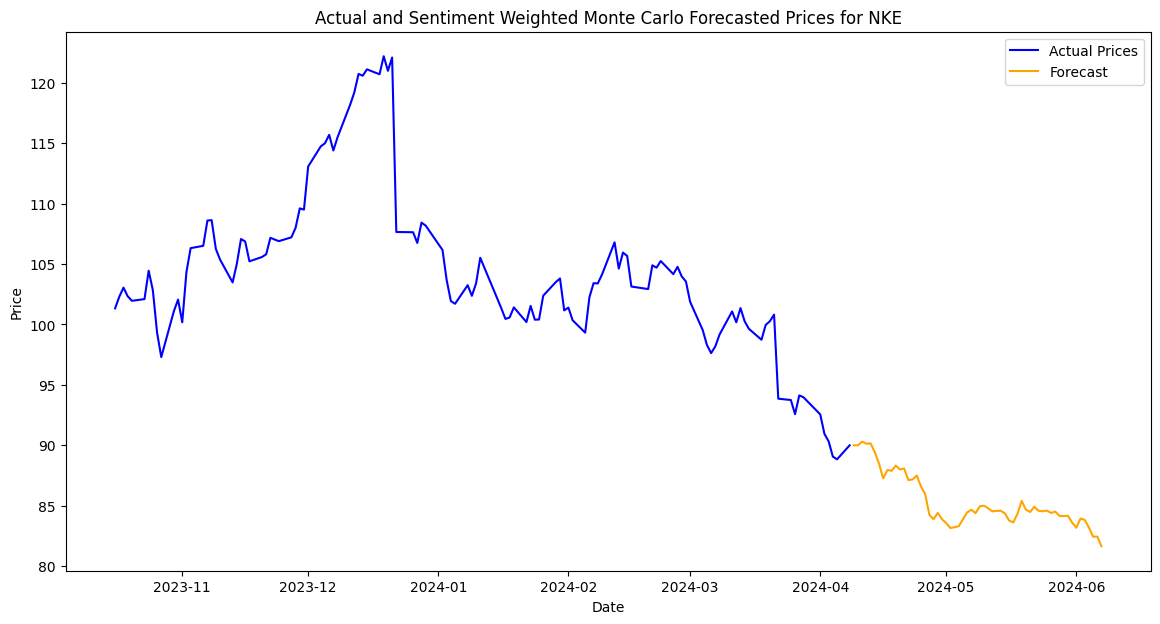

In [153]:
plt.figure(figsize=(14, 7))

# Plot the actual data
plt.plot(actual_data.index, actual_data, color='blue', label='Actual Prices')

# Highlight the forecast period in a different color
plt.plot(forecast_series.index, forecast_series, color='orange', label='Forecast')

# Add labels, title, and legend
plt.title(f"Actual and Sentiment Weighted Monte Carlo Forecasted Prices for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Show the plot
plt.show()